# Are There Any Cross-Exchange Arbitrage Opportunities Left? A Python Series


### A deep dive in Binance and Kraken prices.


## Introduction

Cross-exchange Arbitrage was highly profitable in the early days of cryptocurrency trading. Simple models coded in Python allowed savvy traders to capitalize on price discrepancies between crypto exchanges. But as the market matures and models become more advanced, the question arises: Are there any cross-exchange arbitrage opportunities left?

Let's focus on Binance and Kraken, two of the largest and most popular exchanges. We'll obtain real market data from both their respective APIs. We will analyze Bitcoin ($BTC) prices in USD from  April 20th, 2023, from 00:00:00 to 23:45:00, at 15-minute intervals.

This article will showcase how one can leverage the power of Python to analyze real-time data and determine the viability of arbitrage strategies in today's crypto landscape. Although we'll use real market data, keep in mind that this article is a demo, not financial advice, and aims at mastering python. Join us as we delve into the fascinating realm of cross-exchange arbitrage using Python!

## Part 1: Import libraries

In [30]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta

## Part 2: Defining functions to fetch data from Binance and Kraken APIs

In [31]:
# This function fetches data from Binance API
def get_binance_data(symbol, interval, start_time, end_time):
    url = f"https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&startTime={start_time}&endTime={end_time}"
    response = requests.get(url)
    data = response.json()

    df = pd.DataFrame(data, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])
    df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
    df['Close time'] = pd.to_datetime(df['Close time'], unit='ms')
    return df[['Open time', 'Close time', 'Open', 'High', 'Low', 'Close', 'Volume']]

In [32]:
# This function fetches data from Kraken API
def get_kraken_data(pair, interval, since):
    url = f"https://api.kraken.com/0/public/OHLC?pair={pair}&interval={interval}&since={since}"
    response = requests.get(url)
    data = response.json()['result'][pair]

    df = pd.DataFrame(data, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Weighted average price', 'Number of trades'])
    df['Open time'] = pd.to_datetime(df['Open time'], unit='s')
    df['Close time'] = df['Open time'] + pd.to_timedelta(interval, unit='m')
    return df[['Open time', 'Close time', 'Open', 'High', 'Low', 'Close', 'Volume']]


The query parameters to get data from the APIs are not necessarily the same. For Binance, the query parameters are “symbol”, “interval”, “start_time”, “end_time”, while for Kraken they are “pair”, “interval”, “since”. The goal here is to create functions that will both return a DataFrame with the same desired columns to merge data from both APIs.

## Part 3: Fetching and Merging data from both APIs

In [33]:
# Let's first define a function to convert a datetime object to timestamp in milliseconds (trading data usually is in milliseconds)
def datetime_to_timestamp(dt):
    return int(dt.timestamp() * 1000)

# Setting the date range for fetching our data
start_date = datetime(2023, 4, 19)
end_date = datetime(2023, 4, 22)

# Using our datetime object to timestamp function
start_timestamp = datetime_to_timestamp(start_date)
end_timestamp = datetime_to_timestamp(end_date)

# Fetching Bitcoin data from Binance and Kraken APIs
binance_data = get_binance_data('BTCUSDT', '15m', start_timestamp, end_timestamp)
kraken_data = get_kraken_data('XXBTZUSD', 15, start_timestamp)

# Using the "Open time" column as the key for merging both Binance and Kraken data
merged_data = pd.merge(binance_data, kraken_data, on='Open time', suffixes=('_binance', '_kraken'))

# Price discrepancies: We finish by calculating the price difference between the closing prices from Binance and Kraken
merged_data['Price difference'] = merged_data['Close_binance'].astype(float) - merged_data['Close_kraken'].astype(float)

# We then set the 20th of April from the DataFrame merged_data
filter_start = datetime(2023, 4, 20, 0, 0, 0)
filter_end = datetime(2023, 4, 20, 23, 45, 0)

# We filter the merged_data DataFrame
filtered_data = merged_data[(merged_data['Open time'] >= filter_start) & (merged_data['Open time'] <= filter_end)]
filtered_data

,Open time,Close time_binance,Open_binance,High_binance,Low_binance,Close_binance,Volume_binance,Close time_kraken,Open_kraken,High_kraken,Low_kraken,Close_kraken,Volume_kraken,Price difference
104,2023-04-20 00:00:00,2023-04-20 00:14:59.999,28797.10000000,28818.02000000,28716.60000000,28726.93000000,1151.02399000,2023-04-20 00:15:00,28814.3,28814.3,28728.9,28731.5,28776.3,-4.57
105,2023-04-20 00:15:00,2023-04-20 00:29:59.999,28726.93000000,28918.66000000,28650.58000000,28894.09000000,1342.68298000,2023-04-20 00:30:00,28731.7,28925.1,28729.6,28919.2,28822.1,-25.11
106,2023-04-20 00:30:00,2023-04-20 00:44:59.999,28894.08000000,28965.99000000,28857.65000000,28922.49000000,723.64709000,2023-04-20 00:45:00,28914.0,28950.0,28864.8,28950.0,28890.0,-27.51
107,2023-04-20 00:45:00,2023-04-20 00:59:59.999,28922.49000000,28963.60000000,28897.74000000,28920.01000000,396.77614000,2023-04-20 01:00:00,28949.9,28966.6,28909.4,28928.6,28944.7,-8.59
108,2023-04-20 01:00:00,2023-04-20 01:14:59.999,28920.01000000,28954.03000000,28838.47000000,28870.56000000,700.91267000,2023-04-20 01:15:00,28928.4,28953.4,28855.0,28877.0,28895.1,-6.44
109,2023-04-20 01:15:00,2023-04-20 01:29:59.999,28870.57000000,28900.00000000,28852.28000000,28861.24000000,454.31117000,2023-04-20 01:30:00,28876.9,28903.4,28859.6,28867.3,28883.4,-6.06
110,2023-04-20 01:30:00,2023-04-20 01:44:59.999,28861.24000000,29000.00000000,28861.23000000,28962.77000000,731.91872000,2023-04-20 01:45:00,28867.3,29000.1,28864.9,28980.0,28966.8,-17.23
111,2023-04-20 01:45:00,2023-04-20 01:59:59.999,28962.77000000,28964.57000000,28912.28000000,28934.07000000,474.64074000,2023-04-20 02:00:00,28980.0,28980.1,28925.2,28940.2,28951.6,-6.13
112,2023-04-20 02:00:00,2023-04-20 02:14:59.999,28934.07000000,28958.06000000,28878.90000000,28891.40000000,437.98656000,2023-04-20 02:15:00,28940.2,28971.0,28891.0,28906.4,28948.4,-15.00
113,2023-04-20 02:15:00,2023-04-20 02:29:59.999,28891.40000000,28901.83000000,28824.91000000,28882.11000000,458.11952000,2023-04-20 02:30:00,28905.4,28907.0,28845.1,28895.3,28881.7,-13.19


We now have our data for the 20th of April and have also calculated the price differences between the closing prices from Binance and Kraken. Let's plot the discrepancies.

## Part 4: Plot the 15-Minute Prices Discrepancies

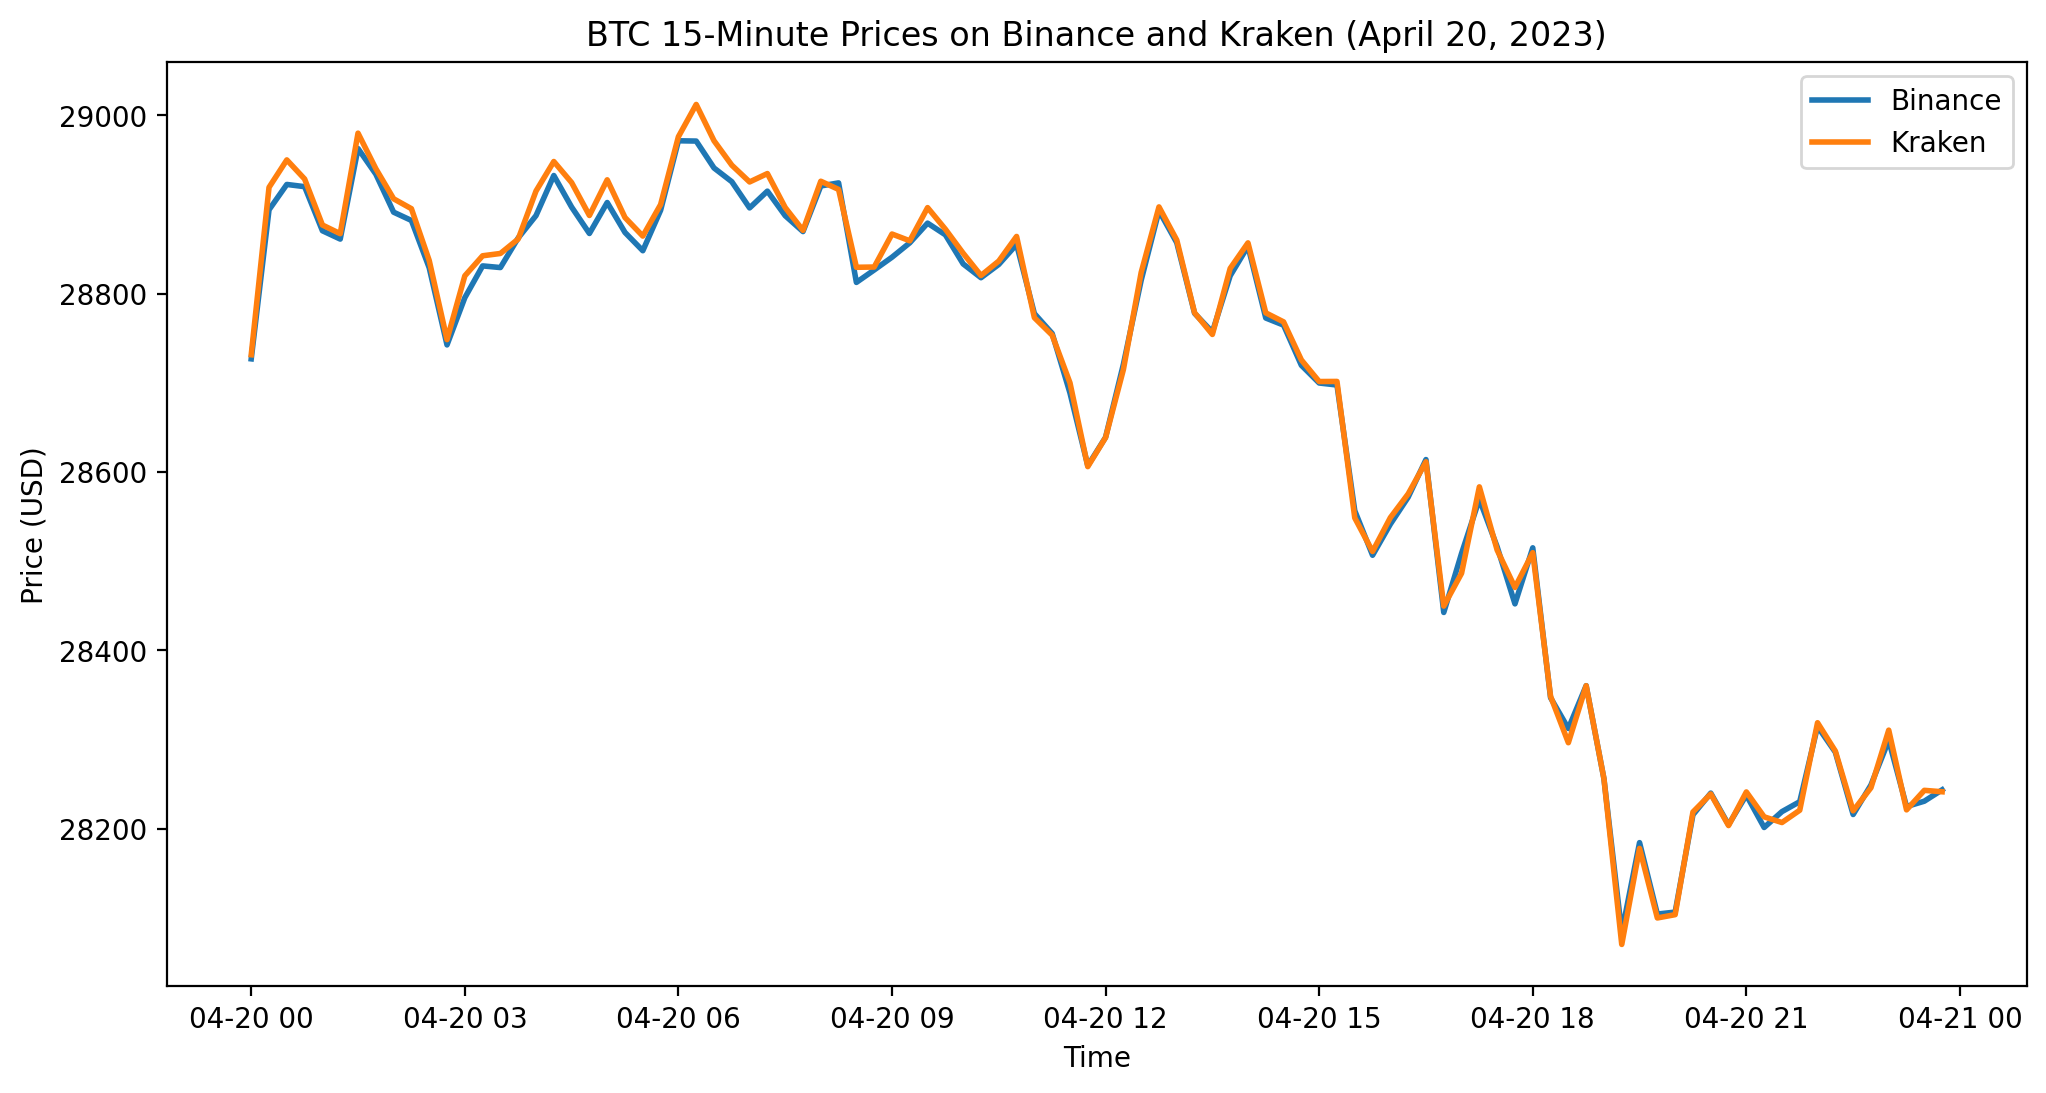

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

ax.plot(filtered_data['Open time'], filtered_data['Close_binance'].astype(float), label='Binance', linewidth=2)
ax.plot(filtered_data['Open time'], filtered_data['Close_kraken'].astype(float), label='Kraken', linewidth=2)

ax.set_title('BTC 15-Minute Prices on Binance and Kraken (April 20, 2023)')
ax.set_xlabel('Time')
ax.set_ylabel('Price (USD)')
ax.legend()

plt.show()

This graph plots the closing prices of $BTC from Binance and Kraken on the 20th of April 2023. The Binance and Kraken price trends are very similar, but they occasionally diverge. This disparity, called spread, is the cross-exchange arbitrage opportunity that traders capitalize on: buy BTC at a lower price on one exchange and sell at a higher price on the other, hence generating profit. Let’s plot these price differences, let’s visualize the spread!

We could directly plot the newly created variable “Price difference” but then the spread would be represented as a negative and positive value. We are however not interested in the direction but the magnitude of the difference between the prices. Therefore, we will create a line graph representing the absolute difference between the closing prices of the two exchanges.

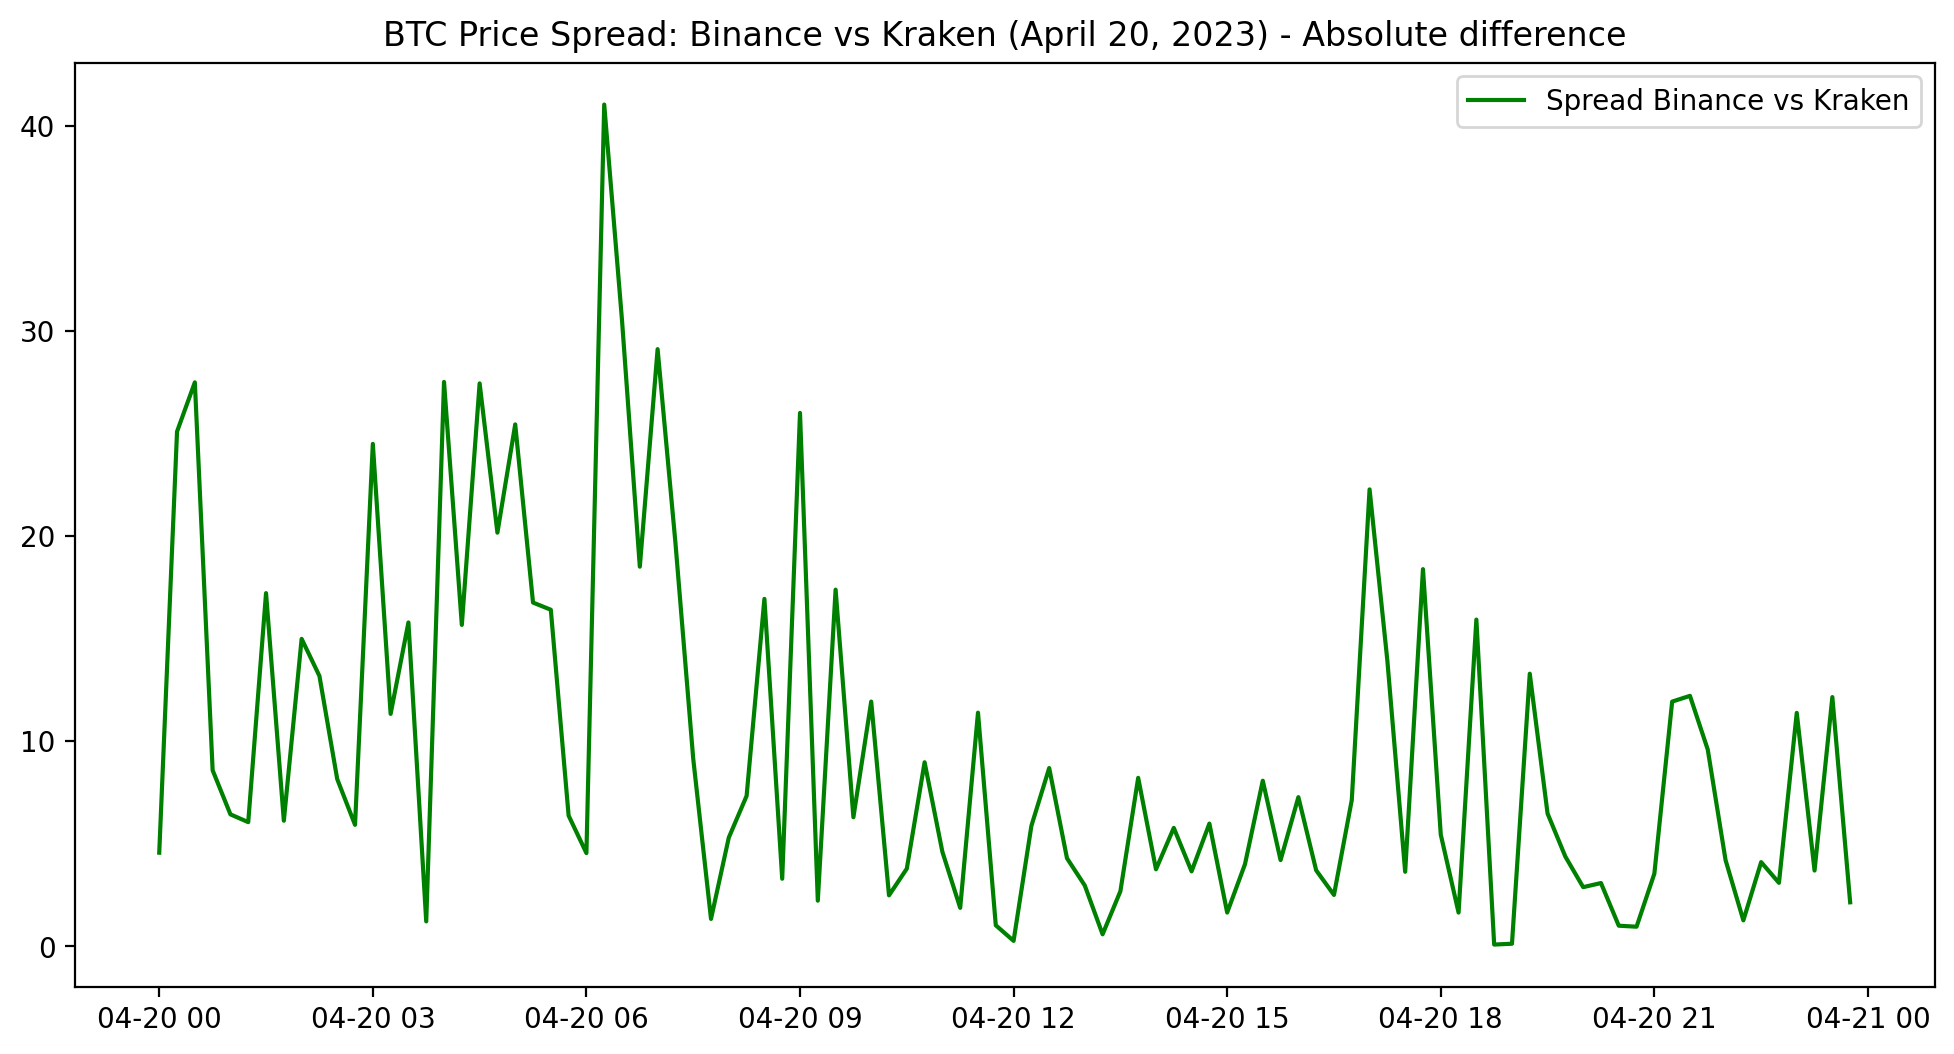

In [52]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=200)

# We calculate the absolute difference between Binance and Kraken closing prices with the abs() function
plt.plot(filtered_data['Open time'], abs(filtered_data['Close_binance'].astype(float) - filtered_data['Close_kraken'].astype(float)), label='Spread Binance vs Kraken', color='green')

plt.title('BTC Price Spread: Binance vs Kraken (April 20, 2023) - Absolute difference')
plt.legend()

## Part 5: Calculating the total spread for the day

In [36]:
# We calculate the total spread for the day in an ideal environment
total_spread = abs(filtered_data['Close_binance'].astype(float) - filtered_data['Close_kraken'].astype(float)).sum()

print(f"Total Spread for the day: {total_spread} USD")

Total Spread for the day: 922.0599999999831 USD


In an ideal trading environment where one could capitalize from every spread, it would be possible to profit from the price discrepancies between Binance and Kraken. Let’s compute the sum of all the spreads. The total spread for the day is 922 USD. However, this figure is theoretical.

## Part 6: Factoring in trading fees

Indeed, in real-world conditions there are several factors to keep in mind such as fees, slippage and other variables like the rapidity of the trading execution.

Let’s factor in trading fees. Exchanges like Binance and Kraken typically charge maker and taker fees. When you execute an arbitrage strategy, it’s vital to include theses fees in your profit calculations. Indeed, the arbitrage opportunity may not generate a profit after factoring in the fees associated to both exchanges.

Suppose you buy 1 BTC on Binance at a lower price and sell it on Kraken at a higher price. Placing a limit order to buy 1 BTC on Binance classifies you as a maker and you’ll have to pay a maker fee when the order is executed. Then, placing a market order on this 1 BTC on Kraken will classify you as a taker and you’ll have to pay a taker fee. See the chart below to see the different fee structures across exchanges.

Maker fee: A maker is someone who places an order that doesn't immediately match with an existing order on the order book. Instead, it "makes" liquidity by adding to the pool of open orders, waiting to be matched. As makers contribute to the overall liquidity of the market, their fees are generally lower than taker fees.

Taker fee: A taker is someone who places an order that is immediately filled by matching it with an existing order on the order book. Takers "take" liquidity from the market by reducing the number of open orders. As a result, taker fees are typically higher than maker fees.

When you execute an arbitrage strategy, it’s vital to include theses fees in your profit calculations. Indeed, the arbitrage opportunity may not generate a profit after factoring in the fees associated to both exchanges.

Here, we apply an average 0.2% trading fee.

In [53]:
# We add and calculate the absolute difference and fees columns in our filtered_data DataFrame
filtered_data['Absolute Price Diff'] = abs(filtered_data['Close_binance'].astype(float) - filtered_data['Close_kraken'].astype(float))
filtered_data['Fees'] = 0.002 * (filtered_data['Close_binance'].astype(float) + filtered_data['Close_kraken'].astype(float))

# We create a new DataFrame with the desired columns using dictionary comprehension
arbitrage_df = pd.DataFrame({column: filtered_data[column] for column in ['Open time', 'Close_binance', 'Close_kraken', 'Absolute Price Diff', 'Fees']})

# We then rename the columns in the DataFrame 'Close_binance' and 'Close_kraken'
arbitrage_df.columns = ['Open time', 'Binance BTC', 'Kraken BTC', 'Absolute Price Diff', 'Fees']
arbitrage_df

/var/folders/r1/32k68tt110177h5kdq1145rw0000gn/T/ipykernel_64237/1623943727.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Absolute Price Diff'] = abs(filtered_data['Close_binance'].astype(float) - filtered_data['Close_kraken'].astype(float))
/var/folders/r1/32k68tt110177h5kdq1145rw0000gn/T/ipykernel_64237/1623943727.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Fees'] = 0.002 * (filtered_data['Close_binance'].astype(float) + filtered_data['Close_kraken'].astype(floa

,Open time,Binance BTC,Kraken BTC,Absolute Price Diff,Fees
104,2023-04-20 00:00:00,28726.93000000,28731.5,4.57,114.91686
105,2023-04-20 00:15:00,28894.09000000,28919.2,25.11,115.62658
106,2023-04-20 00:30:00,28922.49000000,28950.0,27.51,115.74498
107,2023-04-20 00:45:00,28920.01000000,28928.6,8.59,115.69722
108,2023-04-20 01:00:00,28870.56000000,28877.0,6.44,115.49512
109,2023-04-20 01:15:00,28861.24000000,28867.3,6.06,115.45708
110,2023-04-20 01:30:00,28962.77000000,28980.0,17.23,115.88554
111,2023-04-20 01:45:00,28934.07000000,28940.2,6.13,115.74854
112,2023-04-20 02:00:00,28891.40000000,28906.4,15.00,115.59560
113,2023-04-20 02:15:00,28882.11000000,28895.3,13.19,115.55482


## Part 7: Generating Buy and Sell Signals: On which exchange should I buy ? Sell ?

When should we buy or sell on Kraken? When should we buy or sell on Binance?

Let’s say that we will return “0” when Binance BTC price > Kraken BTC Price (buy on Kraken and sell on Binance) and that

We will return “1” when Kraken BTC Price > Binance BTC Price (buy on Binance and sell on Kraken)

In [54]:
# Will return 0 if Binance BTC Price > Kraken BTC Price (buy on Kraken and sell on Binance)
# Will return 1 if Kraken BTC Price > Binance BTC Price (buy on Binance and sell on Kraken)

# np.where(condition, x, y) returns an array with the same shape as the condition
# If the condition is True, it returns the corresponding element from x, otherwise from y
signals_data = np.where(arbitrage_df['Binance BTC'] > arbitrage_df['Kraken BTC'], 0, 1)

# We create a new DataFrame to store the signals
# Set the index of signals_df to match the index of arbitrage_df
signals_df = pd.DataFrame(signals_data, columns=['BuyKrakenSellBinance'], index=arbitrage_df.index)

# We then add the signals to the arbitrage_df DataFrame
arbitrage_df = pd.concat([arbitrage_df, signals_df], axis=1)
arbitrage_df


,Open time,Binance BTC,Kraken BTC,Absolute Price Diff,Fees,BuyKrakenSellBinance
104,2023-04-20 00:00:00,28726.93000000,28731.5,4.57,114.91686,1
105,2023-04-20 00:15:00,28894.09000000,28919.2,25.11,115.62658,1
106,2023-04-20 00:30:00,28922.49000000,28950.0,27.51,115.74498,1
107,2023-04-20 00:45:00,28920.01000000,28928.6,8.59,115.69722,1
108,2023-04-20 01:00:00,28870.56000000,28877.0,6.44,115.49512,1
109,2023-04-20 01:15:00,28861.24000000,28867.3,6.06,115.45708,1
110,2023-04-20 01:30:00,28962.77000000,28980.0,17.23,115.88554,1
111,2023-04-20 01:45:00,28934.07000000,28940.2,6.13,115.74854,1
112,2023-04-20 02:00:00,28891.40000000,28906.4,15.00,115.59560,1
113,2023-04-20 02:15:00,28882.11000000,28895.3,13.19,115.55482,1


When should we buy or sell on Kraken? When should we buy or sell on Binance?

In the **BuyKrakenSellBinance** column:

. **If you see a 0, it means that the Binance BTC price is higher than the Kraken BTC price**. In this case, the call to action is to buy BTC on Kraken and sell BTC on Binance to profit from the price difference.


. **If you see a 1, it means that the Kraken BTC price is higher than the Binance BTC price**. In this situation, the call to action is to buy BTC on Binance and sell BTC on Kraken to profit from the price difference.

## Part 8: Trade Execution

To finish, we have to determine if the arbitrage opportunity is profitable after accounting for trading fees.

### If the absolute price difference is greater than the trading cost, set the value to 0 (execute the trade). This is a profitable trade !

### If the absolute price difference is less than or equal to the trading cost, set the value to 1 (do not execute the trade)

Let's thus count the number of trade profitable (marked with "0")

In [55]:
# Create a new column 'Execute Trade' in the arbitrage_df DataFrame
# If the absolute price difference is greater than the fees, set the value to 0 (execute the trade)
# If the absolute price difference is less than or equal to the fees, set the value to 1 (do not execute the trade)
arbitrage_df['Execute Trade'] = (arbitrage_df['Absolute Price Diff'] <= arbitrage_df['Fees']).astype(int)
arbitrage_df

,Open time,Binance BTC,Kraken BTC,Absolute Price Diff,Fees,BuyKrakenSellBinance,Execute Trade
104,2023-04-20 00:00:00,28726.93000000,28731.5,4.57,114.91686,1,1
105,2023-04-20 00:15:00,28894.09000000,28919.2,25.11,115.62658,1,1
106,2023-04-20 00:30:00,28922.49000000,28950.0,27.51,115.74498,1,1
107,2023-04-20 00:45:00,28920.01000000,28928.6,8.59,115.69722,1,1
108,2023-04-20 01:00:00,28870.56000000,28877.0,6.44,115.49512,1,1
109,2023-04-20 01:15:00,28861.24000000,28867.3,6.06,115.45708,1,1
110,2023-04-20 01:30:00,28962.77000000,28980.0,17.23,115.88554,1,1
111,2023-04-20 01:45:00,28934.07000000,28940.2,6.13,115.74854,1,1
112,2023-04-20 02:00:00,28891.40000000,28906.4,15.00,115.59560,1,1
113,2023-04-20 02:15:00,28882.11000000,28895.3,13.19,115.55482,1,1


In [44]:
number_of_profitable_trades = (arbitrage_df['Execute Trade'] == 0).sum()
print(f"Number of profitable arbitrage trades: {number_of_profitable_trades}")

Number of profitable arbitrage trades: 0


There are unfortunately no trades that are profitable on the 20th of April for us. But nothing stops us from running this python script every day! Why not also use it on less liquid assets such as altcoins? We might catch, at last, a great cross-exchange arbitrage opportunity.